In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

from time import time

import jax
from jax import numpy as jnp
jax.config.update("jax_enable_x64", True)

from plaingaussian.normal import normal, join
from plaingaussian.parametric import pnormal

# Model and benchmarks

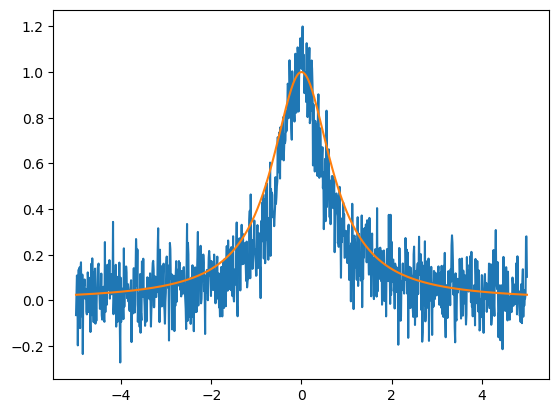

In [7]:
npts = 10 * 10**2
x = jnp.linspace(-5, 5, npts)

def lorentzian(x):
    return 1./(1. + x**2)

def lorentzian_model(params, variables):
    """Lorentzian"""
    [a, lw, sigf, sigm] = params
    [xis, mn] = variables
    return a * lorentzian((sigf * xis + x)/lw) + sigm * mn

xi = [None] * npts
xi[0] = normal(0, 100)
for i in range(npts-1):
    xi[i+1] = xi[i] + normal(0, 1/(npts-1))

xis = join(xi) | {xi[npts//2]: 0}  # cavity frequency random walk
mn = normal(0., 1., size=npts)  # measurement noise

model = pnormal(lorentzian_model, [xis, mn])

p0 = [1., 0.8, 0.5, 0.1]
true_model = lorentzian_model(p0, [xis, mn])

y = true_model.sample()
plt.plot(x, jnp.array([y, true_model.mean()]).T);

In [8]:
%timeit model.a(p0)
%timeit model.da(p0)
%timeit model.cov(p0)
%timeit model.d01cov(p0)
%timeit model.logp(p0, y)
%timeit model.dlogp(p0, y)
%timeit model.fisher(p0)
%timeit model.natdlogp(p0, y)

14.1 ms ± 2.35 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
59.2 ms ± 2.24 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
49.9 ms ± 2.06 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
360 ms ± 25.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
61.7 ms ± 3.31 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
430 ms ± 26.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
557 ms ± 25.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
629 ms ± 21.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Fitting

In [9]:
# Simple fitting
def cross_entropy(args):
    model = lorentzian_model(args, [xis, mn])
    return -model.logp(y)

t0 = time()
min_sol1 = minimize(cross_entropy, (0., 1.5, 1, 1))
print(f"Solution time: {time() - t0:.3g} s")
print("\n")

print(min_sol1)

Solution time: 45.7 s


  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -862.5354896139845
        x: [ 1.026e+00  6.916e-01  4.557e-01 -1.008e-01]
      nit: 40
      jac: [-7.629e-06  0.000e+00  7.629e-06  7.629e-05]
 hess_inv: [[ 9.831e-05  6.589e-05 -5.124e-05  1.437e-06]
            [ 6.589e-05  5.576e-04  6.174e-04  7.920e-06]
            [-5.124e-05  6.174e-04  9.181e-04  6.343e-06]
            [ 1.437e-06  7.920e-06  6.343e-06  5.307e-06]]
     nfev: 495
     njev: 99


In [10]:
# Fitting with jacobian

model = pnormal(lorentzian_model, [xis, mn])

def cross_entropy(args):
    f = -model.logp(args, y)
    g = -model.dlogp(args, y) 
    return (f, g)

t0 = time()
min_sol2 = minimize(cross_entropy, (0, 1.5, 1, 1), jac=True)
print(f"Solution time: {time() - t0:.3g} s")
print("\n")

print(min_sol2)

Solution time: 27.6 s


  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -862.5354896139909
        x: [ 1.026e+00 -6.916e-01  4.557e-01 -1.008e-01]
      nit: 29
      jac: [-2.811e-07 -1.240e-08 -1.515e-08  1.295e-06]
 hess_inv: [[ 4.039e-04  2.151e-04  1.531e-04  1.797e-06]
            [ 2.151e-04  2.669e-03 -2.202e-03 -6.237e-06]
            [ 1.531e-04 -2.202e-03  1.697e-02  3.211e-05]
            [ 1.797e-06 -6.237e-06  3.211e-05  5.224e-06]]
     nfev: 52
     njev: 52


In [12]:
# Natural gradient descent

model = pnormal(lorentzian_model, [xis, mn])

niter = 100
p0 = (0.1, 1.5, 1, 1)

lr0 = 1.
lr = lr0

p = p0  # current parameters
logp_prev = model.logp(p, y)

print(p)

t0 = time()
for i in range(niter):
    try:
        delta = model.natdlogp(p, y)
    except np.linalg.LinAlgError:
        delta = model.dlogp(p, y)

    while True:
        logp_new = model.logp(p + lr * delta, y)

        if logp_prev < logp_new:
            p += lr * delta
            break
        else:
            if abs((logp_prev - logp_new)/logp_prev) < 1e-16:
                break

            lr = lr / 2

    if i % 20 == 0:
        print(p)
        print(logp_new)  # new likelihood

    if abs((logp_prev - logp_new)/logp_prev) < 1e-16:
        break

    logp_prev = logp_new
    lr = lr0

print(f"Solution time: {time() - t0:.3g} s")
print(f"Final learning rate: {lr}, nit: {i+1}, logp: {logp_new}")

(0.1, 1.5, 1, 1)
[  0.82071313  -6.03715203 109.17227987   0.53214031]
-519.9790242785937
[ 1.02561979 -0.69156153  0.45565932  0.10082953]
862.5354896139736
Solution time: 19.3 s
Final learning rate: 1.0, nit: 24, logp: 862.5354896139904
